In [1]:
%load_ext lab_black

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pysal.model import mgwr
from sklearn.preprocessing import PowerTransformer

from urbana.constants import DIR_REPO, DIR_DATA

/home/ernest/anaconda3/envs/urbana/lib/python3.9/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [4]:
# papermill parameters cell
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

OUTPUT_WARNINGS = False
VARIABLE_TO_PREDICT = "Airbnb_Number"
TARGET_THRESHOLD = 5

In [5]:
neigh = gpd.read_file(
    DIR_DATA / "interim/neighbourhoods_geo.json",
)

neigh.set_index("Tag", inplace=True)

neigh.drop(
    ["N_district", "N_neighbourhood"],
    axis=1,
    inplace=True,
)

neigh.dropna(inplace=True)

Region with maximum value : 02_07


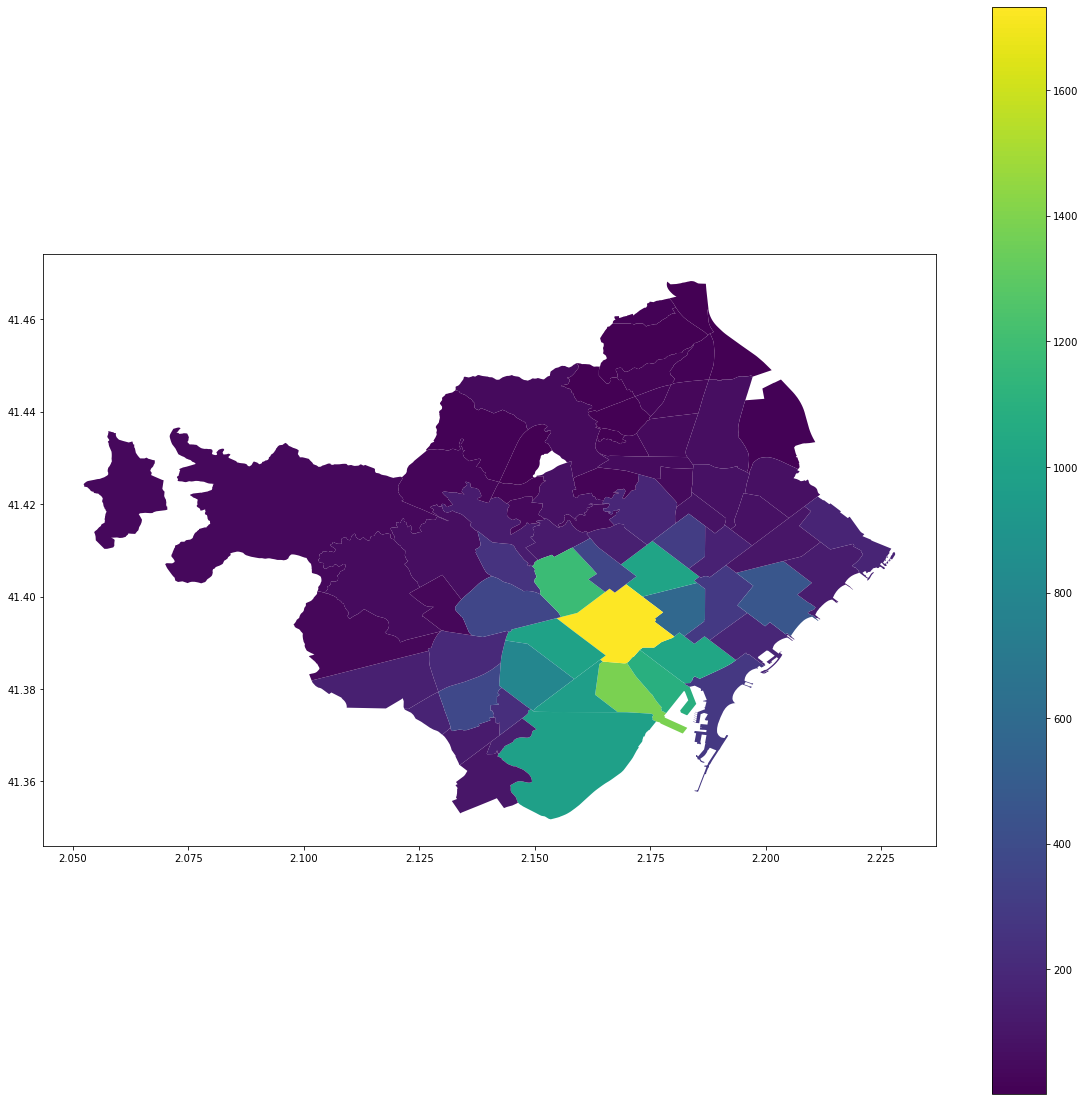

In [6]:
neigh.plot(column=VARIABLE_TO_PREDICT, legend=True, figsize=(20, 20))
id_max_airbnb = neigh["Airbnb_Number"].idxmax()
print("Region with maximum value : " + str(id_max_airbnb))

In [7]:
y = np.array(neigh[VARIABLE_TO_PREDICT]).reshape((-1, 1))
X = neigh.drop(
    [
        "Airbnb_Number",
        "Airbnb_Price",
        "Airbnb_Price_Person",
        "Airbnb_Location_Score",
        "geometry",
    ],
    axis=1,
)
coords = np.column_stack([neigh["geometry"].centroid.x, neigh["geometry"].centroid.y])

geo_info = neigh[["geometry"]]
geo_info["centroid"] = geo_info["geometry"].centroid

In [8]:
# Delete some columns so nrow > ncolumns
X.drop(
    [
        "Education_None",
        "Education_Primary_School",
        "Education_Middle_School",
        "Education_High_School",
        "Percentage_Age_25_39",
        "Percentage_Age_40_64",
        "POI_Daily_Others",
        "POI_State_Agents",
        "Nationality_Armenia",
        "Nationality_Argelia",
        "Nationality_Romania",
    ],
    axis=1,
    inplace=True,
)

In [9]:
X_num = np.array(X)

X_std = (X_num - X_num.mean(axis=0)) / X_num.std(axis=0)
y_std = (y - y.mean(axis=0)) / y.std(axis=0)

# GWR with all the features

In [10]:
gwr_all_selector = mgwr.sel_bw.Sel_BW(
    coords, y_std, X_std, fixed=False, spherical=True, multi=False
)
gwr_all_bw = gwr_all_selector.search()
print("GWR with all features")
print("Bandwith (KNN): " + str(int(gwr_all_bw)))

ValueError: kth(=218) out of bounds (70)

# GWR with chosen and transformed features

In [ ]:
with open("linear_best_neighbouhood.txt") as f:
    best_model = f.read().splitlines()
X_chosen = neigh[best_model]
y_chosen = np.array(neigh[VARIABLE_TO_PREDICT]).reshape((-1, 1))
print(best_model)

In [ ]:
pw_X = PowerTransformer()
pw_X.fit(X)
X_transformed = pw_X.transform(X)

pw_y = PowerTransformer()
pw_y.fit(y)
y_transformed = pw_y.transform(y)

In [ ]:
gwr_chosen_selector = mgwr.sel_bw.Sel_BW(
    coords, y_transformed, X_transformed, fixed=False, spherical=True, multi=False
)
gwr_chosen_bw = gwr_chosen_selector.search()
print("GWR with chosen and transformed features")
print("Bandwith (KNN): " + str(int(gwr_chosen_bw)))

In [ ]:
gwr_chosen_model = mgwr.gwr.GWR(coords, y_transformed, X_transformed, gwr_chosen_bw)
gwr_chosen_results = gwr_chosen_model.fit()
gwr_chosen_results.summary()

# GWR
All of the processes being modeled operate at the same spatial scale

# MGWR
All of the processes being modeled **DO NOT** operate at the same spatial scale